# CUSTOMER SEGMENTATION & MARKET BASKET ANALYSIS: 

## Uncovering customer preferences to create targeted product recommendations.

### Objective :

We have access to four data sets that contain information about customers' orders over time. The goal is to predict which products a user is likely to purchase in their next order. The data sets are anonymized and include a sample of more than 3 million grocery orders from over 200,000 users. For each user, we can observe their transactions, including the sequence of products purchased in each order, the week and hour of day the order was placed, and the time duration between orders. By studying a user's historical purchase patterns, the objective is to provide tailored product recommendations to enhance their shopping experience.

### Approach:

My approach to handling this problem statement involves reducing the dimenionality of the data and dividing customers into segments based on their preferred product categories. Next, through association rule mining, we can identify the frequently purchased items associated with each cluster and use that information to estimate the probability of a customer purchasing another item, given the product they have already viewed or added to their shopping cart.

### Steps:

**PART A:** The first step is to load and clean the dataset, which includes information from various relational databases. We'll combine this information in a systematic way to analyze shoppers' purchase patterns.

**PART B:** To reduce the dataset's dimensionality, we'll use PCA and select the optimal number of principal components. This will ensure that a total explained variance of 80% is achieved.

**PART C:** Using K-means clustering, we'll group customer profiles based on their preferred product categories. We'll use the elbow method to determine the appropriate number of clusters.

**PART D:** For the clustered customer profiles, we'll calculate the top frequently purchased items. Additionally, we'll determine the likelihood of a consumer buying subsequent products based on the items in their basket.

### PART A : Load and Clean the dataset

In [103]:
#Standard data science libraries.
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans #for kmeans algorithm

#For dimensionality reduction.
from sklearn.decomposition import PCA #pca from decomposition module.
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition #decomposition module

#Plotting params.
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb
rcParams['figure.figsize'] = 12, 4
sb.set_style('whitegrid')

np.random.seed(42) # set the seed to make examples repeatable

In [104]:
##LOAD THE DATASET 

#Prior Dataset
prior = pd.read_csv("order_products__prior.csv")

#Order_Train Dataset.
order_train = pd.read_csv("order_products__train.csv")

#Orders Dataset.
orders = pd.read_csv("orders.csv")

#Products
products = pd.read_csv("products.csv")

#Aisles
aisles = pd.read_csv("aisles.csv")

#Departments
departments = pd.read_csv("departments.csv")

In [105]:
#PREPPING THE DataFrame TO BE FED AS INPUT FOR THE CLUTERING ALGORITHM
# Inspect all the dataframes, join them and make a combined df to form clusters. 

In [4]:
#Put them in a list to print shape.
combined_df_list = [products, orders, departments, aisles, prior, order_train]

In [5]:
#Check the size of the datasets.
for i in combined_df_list:
    print (i.shape)
#There are two df's which are very large in size, subset to use it on local machine with limited compute power.
del combined_df_list

(49688, 4)
(3421083, 7)
(21, 2)
(134, 2)
(32434489, 4)
(1384617, 4)


In [6]:
#Products Dataframe
products.head(2)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13


In [7]:
#Departments Dataframe
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
#Aisles Dataframe - Products are kept in aisles.
aisles.head(2)
aisle_name = aisles['aisle']
aisle_name

0           prepared soups salads
1               specialty cheeses
2             energy granola bars
3                   instant foods
4      marinades meat preparation
                  ...            
129      hot cereal pancake mixes
130                     dry pasta
131                        beauty
132    muscles joints pain relief
133    specialty wines champagnes
Name: aisle, Length: 134, dtype: object

In [9]:
#Orders Dataframe
orders.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0


In [10]:
#Orders Train Dataframe
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [11]:
#Products in Orders (Prior) - These files specify which products were purchased in each order. Contains Previous Orders.
prior.head(2) #notice the reordered feature.


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1


In [12]:
#Since the dataframe is too big for in memory computation, reducing prior to only 500k rows. 
prior = prior [:500000]

In [13]:
#Merge 1 - Prior and Orders DF (Joining Orders to prior df)
#Combining the Prior and Orders dataframe - shows which user ordered what products and in which order.
df1 = pd.merge(prior, orders, on= 'order_id')
df1.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0


In [14]:
#Merge 2
#Combining the department and aisle df's to product df. 
prod_aisles = pd.merge(products, aisles, on = 'aisle_id')
df2 = pd.merge(prod_aisles, departments, on = 'department_id')
df2.head(2)

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks


In [15]:
#Combining df1 anf df2
combined_df = pd.merge(df1, df2, on = 'product_id').reset_index(drop=True)
combined_df.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs


In [16]:
#These are null values in the feature 'days_since_prior_order'
combined_df[combined_df['days_since_prior_order'].isnull()].head(2)

# This is refelective of the fact that there are many cutomer who did not come in for a repurchase yet.

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
39,5733,33120,8,0,92179,prior,1,6,10,NaN,Organic Egg Whites,86,16,eggs,dairy eggs
53,8762,33120,4,0,68183,prior,1,3,8,NaN,Organic Egg Whites,86,16,eggs,dairy eggs


### The top 10 customers who have ordered the maximum number of products across all their transactions

In [17]:
#Most ordering customer. Favourite Customer?
pd.DataFrame(combined_df.groupby('user_id')['product_id'].count()).sort_values('product_id', ascending=False).head(10)

#User_id = 142131

,product_id
user_id,
142131,176
169550,161
134465,142
100330,138
5360,137
118860,131
2258,130
290,125
6409,125


### The Top 10 products that were ordered most from the retailer across all buyers

In [18]:
#Most ordered items.
pd.DataFrame(combined_df['product_name'].value_counts()).head(10)

,product_name
Banana,7365
Bag of Organic Bananas,5920
Organic Strawberries,4023
Organic Baby Spinach,3797
Organic Hass Avocado,3317
Organic Avocado,2712
Large Lemon,2355
Strawberries,2225
Organic Raspberries,2177
Limes,2116


### The Top 5 products that were most sold per aisle 

In [19]:
#Most sold items as per aisle.
pd.DataFrame(combined_df['aisle'].value_counts()).head(5)

,aisle
fresh fruits,56326
fresh vegetables,52073
packaged vegetables fruits,27347
yogurt,22485
packaged cheese,14960


In [20]:
combined_df.shape

(500000, 15)

## Note on Clustering Approach:

Our goal was to cluster customers based on their purchasing patterns. We noticed that there are 134 aisle categories that broadly categorize the products, and we used this information to capture the customers' preferred product choices based on these categories.

### Capturing Customer Preferences at a More Granular Level

To capture customer preferences at a more granular level, we can perform customer segmentation on more detailed data on their preferred product choices. This information is available in the product table, and analyzing it would provide us with more specific insights into customer behavior.

### Recommendations for incorporating customer demographic information & RFM score prior to segmenting customers
 
**Incorporating RFM Score:**
Lastly, to effectively segment customers, we recommend utilizing an RFM (Recency, Frequency, Monetary) score. This score takes into account a customer's recency, frequency, and monetary value to create a more accurate representation of their overall value to the business. With this score, we can identify high-value customers who are most likely to make future purchases and tailor our marketing strategies accordingly. By incorporating customer demographics and RFM scores, we can gain valuable insights into customer behavior and preferences, allowing us to make data-driven decisions that enhance customer satisfaction and improve business outcomes.

**Customer Monetary Value:**
To calculate the total monetary value of each customer, we can use the price of each product in the dataset to determine the amount spent by the customer across multiple transactions. But in this dataset we do not have the price of the products, hence we haven't included that in the analysis)

**Customer Recency:**
We have already included customer recency in the dataset, which is measured by the variable "days_since_prior_order". This variable tracks the number of days since the customer's last purchase.

**Customer Frequency:**
Frequency refers to how often a customer makes purchases from the store. We can calculate this by finding the average time between transactions for each customer.

**Incorporating Consumer Demographics:**
To further refine customer segmentation, we recommend including additional information about customer demographics. This may include factors such as age, gender, location, and income level. By including this information, we can delve deeper and study in-depth the behavioral patterns of various customer segments and the factors that influence their product choices.


### PART B:
To reduce the dataset's dimensionality, we'll use PCA and select the optimal number of principal components. This will ensure that a total explained variance of 90% is achieved.

In [21]:
#Using aisles and user_id. This shows the users that purchased items from which aisle.
user_by_aisle_df = pd.crosstab(combined_df['user_id'], combined_df['aisle'])
user_by_aisle_df.head(2)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [22]:
#The final dataframe has about 134 features.
user_by_aisle_df.shape

(39834, 134)

In [23]:
#Standardization is not needed in this case.
user_by_aisle_df.describe() #this confirms that the values dont need to be standardized since they're all 'quantity'.

#The aisles with the highest mean sales. 
user_by_aisle_df.describe().loc['mean'].sort_values(ascending=False).head(10)

aisle
fresh fruits                     1.414018
fresh vegetables                 1.307250
packaged vegetables fruits       0.686524
yogurt                           0.564468
packaged cheese                  0.375559
milk                             0.344304
water seltzer sparkling water    0.320781
chips pretzels                   0.275694
soy lactosefree                  0.252448
bread                            0.231963
Name: mean, dtype: float64

In [24]:
#Taking array of 'user_by_aisle_df'. To use to perform PCA 
X = user_by_aisle_df.values

In [25]:
#Performing PCA on the X df 
from sklearn.decomposition import PCA

pca = PCA()
X_pca_old = pca.fit_transform(X)



In [26]:
# find number of components that explain 90% variance
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
n_components = np.argmax(cum_var_exp >= 0.9) + 1

# perform PCA again with the chosen number of components
pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X)
n_components

51

We can see that a total of 51 components can explain a variance of 90% in the user_aile data frame.

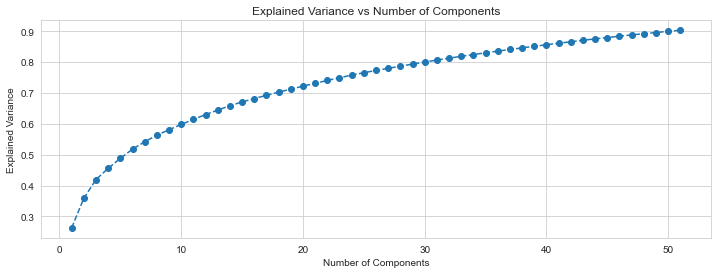

In [27]:
#Plot the xplained variance Vs. The Number of components.
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.show()

In [28]:
#Check the amount of variance explained by the chosen number of components.
pca.explained_variance_ratio_.sum()

0.9029788590466903

### PART C:

Using K-means clustering, we'll group customer profiles based on their preferred product categories (as captured by the user_aisles_df). We'll use the elbow method to determine the appropriate number of clusters.

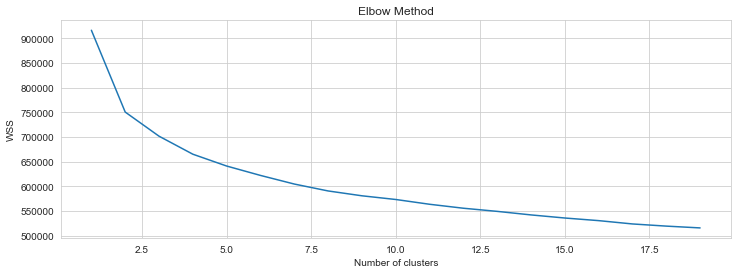

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# calculate the within-cluster sum of squares (WSS) for different values of k
wss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wss.append(kmeans.inertia_)

# plot the WSS curve
plt.plot(range(1, 20), wss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.show()

#Choen number of cluster as 5 

### The elbow method to determine the appropraite number of clusters.

The elbow method is a common technique used to determine the optimal number of clusters in a dataset for clustering analysis. It works by calculating the sum of squared distances between each data point and its assigned centroid for different numbers of clusters. As the number of clusters increases, the sum of squared distances typically decreases, but at a decreasing rate.

To use the elbow method, we plot the sum of squared distances against the number of clusters and look for the "elbow" point in the plot, which is the point of diminishing returns where the rate of improvement in sum of squared distances starts to level off. This elbow point represents the optimal number of clusters for the given dataset.

**Here we choose the optimal number of clusters as 5.0 as per the graph.**

In [30]:
kmeans = KMeans(n_clusters=5)
X_clustered = kmeans.fit_predict(X_pca) #fit_predict on chosen components only.

**Here we Visulaize the customer cluster with the Pricipal components 1 & 2 as the X and Y axis**

The observations/ customers have been classified into 5 makor segments denoted by the 5 different colors in the graph

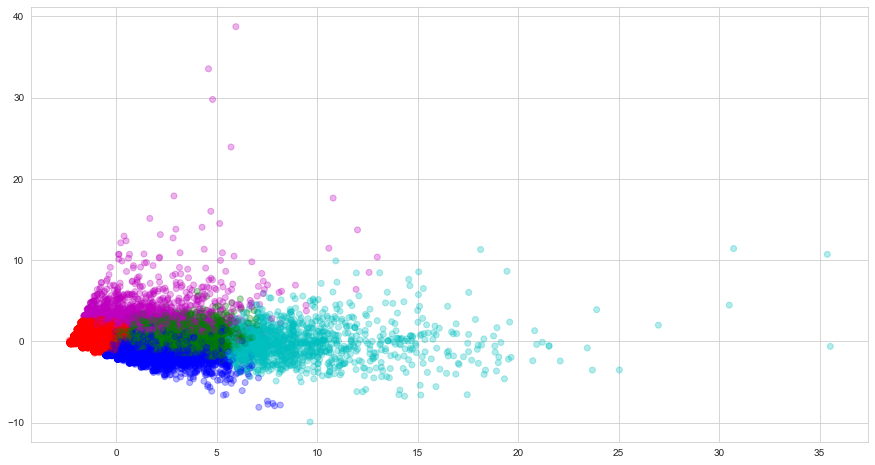

In [69]:
#Visualize it.

label_color_mapping = {0:'r', 1: 'g', 2: 'b',3:'c' , 4:'m'}
label_color = [label_color_mapping[l] for l in X_clustered]

#Scatterplot showing the cluster to which each user_id belongs.
plt.figure(figsize = (15,8))
plt.scatter(X_pca[:,0],X_pca[:,2], c= label_color, alpha=0.3) 
plt.xlabel = 'PC1'
plt.ylabel = 'PC2'
plt.show()

In [32]:
#This contains all the clusters which are to be mapped to each user_id in the user_by_aisle_df.
X_clustered.shape

(39834,)

In [33]:
#Mapping clusters to users.
user_by_aisle_df['cluster']=X_clustered

In [34]:
#Checking cluster concentration. 
user_by_aisle_df['cluster'].value_counts().sort_values(ascending = False)

0    25238
2     6426
1     5185
4     1656
3     1329
Name: cluster, dtype: int64

**Distribution on Customers across different segments**

The table shows the number of customers in each segment. Segment 0 has the highest number of customers, with 25,238 individuals. Segment 2 has the second highest number, with 6,426 customers. Segment 1 has 5,185 customers, while segment 4 and 3 have 1,656 and 1,329 customers respectively

In [70]:
#Get the mean most frequenty purchased and least frequently purchased items each cluster 
cluster_means = user_by_aisle_df.groupby('cluster').mean()
#print(cluster_means)

max_values = cluster_means.max(axis=1)
max_cols = cluster_means.idxmax(axis=1)
result_df = pd.concat([max_values, max_cols], axis=1)
result_df.columns = ['Max Value', 'Column Name']
print(result_df)

min_values = cluster_means.min(axis=1)
min_cols = cluster_means.idxmin(axis=1)
result_df = pd.concat([min_values, min_cols], axis=1)
result_df.columns = ['Min Value', 'Column Name']
print(result_df)

         Max Value       Column Name
cluster                             
0         0.509153      fresh fruits
1         4.334812  fresh vegetables
2         3.564893      fresh fruits
3         7.978179  fresh vegetables
4         4.746377            yogurt
         Min Value   Column Name
cluster                         
0         0.001268  frozen juice
1         0.001543   facial care
2         0.001556        beauty
3         0.000000  eye ear care
4         0.001208  frozen juice


**We are analyzing customer behavior for different product categories, segmented by cluster.** 

The output shows that for **cluster 0**, fresh fruits has the highest mean value, while frozen juice has the lowest mean value. For **cluster 1**, fresh vegetables has the highest mean value, while facial care has the lowest mean value. For **cluster 2**, fresh fruits has the highest mean value, while beauty has the lowest mean value. For **cluster 3**, fresh vegetables has the highest mean value, while eye ear care has the lowest mean value. Finally, for **cluster 4**, yogurt has the highest mean value, while frozen juice has the lowest mean value.

Therefore, we can infer that there are differences in customer behavior across different clusters/segments. For example, customers in cluster 3 tend to purchase fresh vegetables more frequently, while customers in cluster 4 tend to purchase yogurt more frequently. These insights can be used by the company to tailor their marketing and product strategies for different clusters and product categories, in order to maximize customer engagement and sales.







### PART D:

We will analyze the probability of customers purchasing additional products based on the items already present in their shopping cart for the clustered customer profiles using an **Apriori algorithm**. This algorithm will help us identify frequent itemsets, which are groups of items that tend to be purchased together. By examining the frequent itemsets, we can determine the likelihood of a customer purchasing additional products based on the items already present in their shopping cart. This information can be used to make data-driven decisions about marketing and product recommendations.

In [75]:
# Merge user_by_aisle_df with combined_df on user_id column
combined_df = pd.merge(combined_df, user_by_aisle_df[['cluster']], on='user_id')

# Rename the column to 'cluster'
combined_df = combined_df.rename(columns={'cluster': 'cluster'})

# Print the first few rows of the updated combined_df DataFrame
print(combined_df.head())

   order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         2       33120                  1          1   202279    prior   
1         2       28985                  2          1   202279    prior   
2         2        9327                  3          0   202279    prior   
3         2       45918                  4          1   202279    prior   
4         2       30035                  5          0   202279    prior   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             3          5                  9                     8.0   
1             3          5                  9                     8.0   
2             3          5                  9                     8.0   
3             3          5                  9                     8.0   
4             3          5                  9                     8.0   

            product_name  aisle_id  department_id               aisle  \
0     Organic Egg Whites        86   

In [76]:
#Importing Libraries
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [77]:
#CLUSTER 0
#Checking with only a few samples. Concept is replicable.
np.random.seed(942) # set the seed to make examples repeatable

df2 = combined_df[['user_id', 'product_name', 'cluster']]
df2_cluster0 = df2.sample(n=2000)[df2['cluster'] == 0]

basket0 = pd.crosstab(df2_cluster0['user_id'],df2_cluster0['product_name']).astype('bool').astype('int')

/var/folders/cx/l8xqbzn90mxddwspxtjx6xg00000gn/T/ipykernel_89384/2571751106.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2_cluster0 = df2.sample(n=2000)[df2['cluster'] == 0]


In [78]:
#Checking and removing index.
basket0=basket0.reset_index(drop=True)
basket0.index

RangeIndex(start=0, stop=758, step=1)

In [79]:
#Lets see if the format is correct.
basket0.head(2)

product_name,0% Greek Strained Yogurt,100% Apple Juice,100% Australian Tea Tree Oil,100% Carrot Juice,100% Florida Orange Juice,100% Juice,100% Juice Apple Juice,"100% Juice, Apple",100% Liquid Egg Whites,100% Raw Coconut Water,...,Whole Wheat Sourdough,Wild Berry Sparkling Energy Water,Yellow Bell Pepper,Yellow Corn Organic Tortillas,Yellow Corn Taco Shells,Yellow Onions,Yogurt Pretzels,Zero Calorie Sweetener,Zero Rise Orange,Zinfandel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TOP 20 most frequently bought items for Cluster 0

In [80]:
#Calling apriori algorithm on dummified data - basket.
frequent_itemsets0=apriori(basket0, min_support=0.00002, use_colnames=True).sort_values('support', ascending=False) 

#These are all the POPULAR (Top 20) items purchased from the store.
frequent_itemsets0.head(20)

/Users/jyomohan/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
43,0.011873,(Banana)
648,0.005277,(Unsweetened Original Almond Breeze Almond Milk)
367,0.005277,(Organic Fuji Apple)
407,0.005277,(Organic Raspberries)
218,0.005277,(Hass Avocados)
593,0.005277,(Sparkling Water Grapefruit)
40,0.005277,(Bag of Organic Bananas)
411,0.003958,(Organic Reduced Fat 2% Milk)
342,0.003958,(Organic Baby Spinach)
581,0.003958,(Soda)


In [81]:
#Lets check the length of the item sets using a tini lambda function.
frequent_itemsets0['length'] = frequent_itemsets0['itemsets'].apply(lambda x: len(x))
frequent_itemsets0.tail()

,support,itemsets,length
239,0.001319,(I Heart Baby Kale),1
240,0.001319,(Ice Cream Sandwiches Vanilla),1
241,0.001319,"(Ice Cream, Mint Chip)",1
242,0.001319,(Instant Oatmeal Variety Pack),1
698,0.001319,"(Organic Pure 85% Dark Chocolate Bar, Super Se...",2


In [82]:
#Putting a new filter to get all items with length 3 or more. (this means items purchased together)
frequent_itemsets0[frequent_itemsets0['length'] >= 2]

,support,itemsets,length
685,0.001319,"(85% Lean Ground Turkey, Old Fashioned Rolled ...",2
686,0.001319,"(Green Jalapeno Pepper Sauce, Clean Linen Air ...",2
687,0.001319,"(Organic Promise Autumn Wheat Cereal, Egg & Gr...",2
688,0.001319,"(Zero Rise Orange, Fresh Lavender Super Odor N...",2
689,0.001319,"(Fusion Manual Men's Razor Blade Refills, Prem...",2
690,0.001319,"(Organic Raw Unfiltered Apple Cider Vinegar, G...",2
691,0.001319,"(High Protein Bar Chunky Peanut Butter, Light ...",2
692,0.001319,"(Honey Wheat Rolls, Honey Maid Graham Crackers)",2
693,0.001319,"(Stackers Kosher Dill Pickles, Honey Mustard S...",2
694,0.001319,"(Turkey, Kettle Cooked Sea Salt & Vinegar Pota...",2


In [83]:
#FIRST PART - CONFIDENCE

#For association rules, metric can be either confidence or lift. Second argument is minimum threshold (0.5).
#Trying confidence first.
rules0 = association_rules(frequent_itemsets0, metric="confidence", min_threshold=0.5)
rules0.head()

#The minimum confidence level starts at 0.5 (confidence column). How likely is it for item C to be purchased if A was purchased?
#Hence if 'Kidz All Natural Baked Chicken Nuggets' was purchased, it is extremely likely that 'Quart Sized Easy Open Freezer Bags' will be purchased in the same transaction. 
#Confidence tells us if item C is purchased, how likely will item A be purchased too.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(85% Lean Ground Turkey),(Old Fashioned Rolled Oats),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000
1,(Old Fashioned Rolled Oats),(85% Lean Ground Turkey),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000
2,(Green Jalapeno Pepper Sauce),(Clean Linen Air Freshener),0.002639,0.001319,0.001319,0.5,379.0,0.001316,1.997361,1.000000
3,(Clean Linen Air Freshener),(Green Jalapeno Pepper Sauce),0.001319,0.002639,0.001319,1.0,379.0,0.001316,inf,0.998679
4,(Organic Promise Autumn Wheat Cereal),(Egg & Green Chile Burrito),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000


In [84]:
#SECOND PART - LIFT

#Changing metric to lift. Minimum threshold is 1.
rules0 = association_rules(frequent_itemsets0, metric="lift", min_threshold=1)
rules0.head()

#Lift tells how likely are items bought together as opposed to being bought individually.
#Row 0: If Kidz All Natural Baked Chicken Nuggets is purchased, then Quart Sized Easy Open Freezer Bags will be purchased too.
#Row 1: If Quart Sized Easy Open Freezer Bags item is purchased, then Kidz All Natural Baked Chicken Nuggets will be purchased. As there is SLIGHTLY more confidence in row1 (compared to row0).

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(85% Lean Ground Turkey),(Old Fashioned Rolled Oats),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000
1,(Old Fashioned Rolled Oats),(85% Lean Ground Turkey),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000
2,(Green Jalapeno Pepper Sauce),(Clean Linen Air Freshener),0.002639,0.001319,0.001319,0.5,379.0,0.001316,1.997361,1.000000
3,(Clean Linen Air Freshener),(Green Jalapeno Pepper Sauce),0.001319,0.002639,0.001319,1.0,379.0,0.001316,inf,0.998679
4,(Organic Promise Autumn Wheat Cereal),(Egg & Green Chile Burrito),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000


In [85]:
#THIRD PART - CONFIDENCE AND LIFT

#Select life>5 and confidence >.5
rules0[(rules0['lift'] >= 5) & (rules0['confidence']>= 0.5)] 

#Now these items will be mostly be bought together. So you can make Cross-sell/upsell strategies based on that.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(85% Lean Ground Turkey),(Old Fashioned Rolled Oats),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000
1,(Old Fashioned Rolled Oats),(85% Lean Ground Turkey),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000
2,(Green Jalapeno Pepper Sauce),(Clean Linen Air Freshener),0.002639,0.001319,0.001319,0.5,379.0,0.001316,1.997361,1.000000
3,(Clean Linen Air Freshener),(Green Jalapeno Pepper Sauce),0.001319,0.002639,0.001319,1.0,379.0,0.001316,inf,0.998679
4,(Organic Promise Autumn Wheat Cereal),(Egg & Green Chile Burrito),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000
5,(Egg & Green Chile Burrito),(Organic Promise Autumn Wheat Cereal),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000
6,(Zero Rise Orange),(Fresh Lavender Super Odor Neutralizer Long La...,0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000
7,(Fresh Lavender Super Odor Neutralizer Long La...,(Zero Rise Orange),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000
8,(Fusion Manual Men's Razor Blade Refills),(Premium Selects Brussels Sprouts),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000
9,(Premium Selects Brussels Sprouts),(Fusion Manual Men's Razor Blade Refills),0.001319,0.001319,0.001319,1.0,758.0,0.001318,inf,1.000000


### How to infer the above output, what does it signify? 

The above output represents the results of an association rule mining algorithm, which identifies interesting relationships between items in a dataset based on their co-occurrence patterns.

In this output, each row represents an association rule, which consists of an antecedent (the item(s) that precede the consequent) and a consequent (the item(s) that follow the antecedent) along with various metrics that describe the strength and significance of the relationship between them.

### What is antecedant and consequent?

The antecedent and consequent in this output refer to the items that occur together in the dataset. For example, in the first row, the antecedent is "85% Lean Ground Turkey" and the consequent is "Old Fashioned Rolled Oats", which means that these two items were found to co-occur frequently in the dataset.

### What does Lift signify?

The Lift value in each row signifies the strength of the relationship between the antecedent and consequent. A Lift value greater than 1 indicates that the presence of the antecedent increases the likelihood of the consequent, while a Lift value less than 1 indicates that the presence of the antecedent decreases the likelihood of the consequent. A Lift value of exactly 1 indicates that the antecedent and consequent are independent.

### What is antecendant and consequent support?

The antecedent and consequent support values in each row represent the proportion of transactions that contain the antecedent and consequent, respectively. Antecedent support is the fraction of transactions that contain the antecedent, while consequent support is the fraction of transactions that contain the consequent. These values are used to calculate the other metrics in the output, such as support, confidence, and Lift.



### INFERENCE BASED ON APRIORI OUTPUT FOR CLUSTER '0' CUSTOMERS 

* Customers in cluster 0 tend to purchase 85% Lean Ground Turkey and Old Fashioned Rolled Oats together with 100% confidence. This means that whenever a customer in this cluster buys one of these items, they are highly likely to also buy the other item. However the support for both antecedent and consequent is low, indicating that this combination does not occur frequently.

* The same goes for Organic Promise Autumn Wheat Cereal and Egg & Green Chile Burrito, which are also frequently purchased together with 100% confidence by customers in cluster 0.

* On the other hand, customers in cluster 0 tend to purchase Green Jalapeno Pepper Sauce and Clean Linen Air Freshener together with a confidence of 50%. This suggests that while these two items are often bought together by customers in this cluster, there is still a chance that a customer who buys one of these items may not buy the other.

* The other rules also indicate similar relationships between different items, such as "Green Jalapeno Pepper Sauce" and "Clean Linen Air Freshener" or "Organic Promise Autumn Wheat Cereal" and "Egg & Green Chile Burrito". The high lift values in all rules suggest that these item combinations are frequently bought together.

In [86]:
#CLUSTER 1
#Checking with only a few samples. Concept is replicable.
np.random.seed(942) # set the seed to make examples repeatable

df2 = combined_df[['user_id', 'product_name', 'cluster']]
df2_cluster1 = df2.sample(n=2000)[df2['cluster'] == 1]

basket = pd.crosstab(df2_cluster1['user_id'],df2_cluster1['product_name']).astype('bool').astype('int')

/var/folders/cx/l8xqbzn90mxddwspxtjx6xg00000gn/T/ipykernel_89384/674016467.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2_cluster1 = df2.sample(n=2000)[df2['cluster'] == 1]


In [87]:
#Checking and removing index.
basket1=basket.reset_index(drop=True)
basket1.index

RangeIndex(start=0, stop=346, step=1)

In [88]:
#Lets see if the format is correct.
basket1.head(2)

product_name,100% Egg Whites,100% Whole Wheat Bread,50/50 Mix Spring Mix and Baby Spinach Salad Blend,All-Seasons Salt,Almond Milk Peach Yogurt,Apples + Strawberries Organic Nibbly Fingers,Arnica Montana 30 C,Asparagus,Asparation/Broccolini/Baby Broccoli,Avocado Roll,...,Whipped Cream Cheese,White Truffle Oil,Whole Grains Oatnut Bread,Whole Milk Plain Yogurt,Whole Wheat Pita Bread,Wildflower Honey,Wonderful 100% Pomegranate Juice,Yellow Bell Pepper,Yellow Onions,Zen Tea
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
#Calling apriori algorithm on dummified data - basket.
frequent_itemsets1=apriori(basket1, min_support=0.00002, use_colnames=True).sort_values('support', ascending=False) 

#These are all the POPULAR (Top 20) items purchased from the store.
frequent_itemsets1.head(20)

/Users/jyomohan/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
17,0.020231,(Banana)
47,0.014451,(Cucumber Kirby)
219,0.014451,(Organic Yellow Onion)
30,0.011561,(Carrots)
220,0.011561,(Organic Zucchini)
199,0.011561,(Organic Small Bunch Celery)
64,0.011561,(Fresh Cauliflower)
67,0.008671,(Garlic)
186,0.008671,(Organic Red Onion)
122,0.008671,(Organic Baby Arugula)


In [91]:
#Lets check the length of the item sets using a tini lambda function.
frequent_itemsets1['length'] = frequent_itemsets1['itemsets'].apply(lambda x: len(x))
frequent_itemsets1.head()

,support,itemsets,length
17,0.020231,(Banana),1
47,0.014451,(Cucumber Kirby),1
219,0.014451,(Organic Yellow Onion),1
30,0.011561,(Carrots),1
220,0.011561,(Organic Zucchini),1


In [93]:
#Putting a new filter to get all items with length 3 or more. (this means items purchased together)
frequent_itemsets1[frequent_itemsets1['length'] >= 2]

,support,itemsets,length
303,0.00289,"(Organic Roma Tomato, Red Onion)",2
302,0.00289,"(Organic Garlic, Organic Ginger Root)",2
301,0.00289,"(Organic Romaine Leaf, Organic Gala Apples)",2
300,0.00289,"(Vitamin D Milk, Organic Coconut Milk)",2
299,0.00289,"(Organic Broccoli, Unsweetened Organic Coconut...",2
298,0.00289,"(Organic Baby Spinach, Organic Green Onions)",2
297,0.00289,"(Milk Free Better Than Sour Cream, Organic Tom...",2
296,0.00289,"(Jalapeno Peppers, Queso Chihuahua Quesadilla ...",2
295,0.00289,"(Organic Milk Reduced Fat, 2% Milkfat, Corn To...",2
294,0.00289,"(Organic Iceberg Lettuce, Chicken Stock)",2


In [94]:
#FIRST PART - CONFIDENCE

#For association rules, metric can be either confidence or lift. Second argument is minimum threshold (0.5).
#Trying confidence first.
rules1 = association_rules(frequent_itemsets1, metric="confidence", min_threshold=0.5)
rules1.head()

#The minimum confidence level starts at 0.5 (confidence column). How likely is it for item C to be purchased if A was purchased?
#Hence if 'Kidz All Natural Baked Chicken Nuggets' was purchased, it is extremely likely that 'Quart Sized Easy Open Freezer Bags' will be purchased in the same transaction. 
#Confidence tells us if item C is purchased, how likely will item A be purchased too.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Roma Tomato),(Red Onion),0.00578,0.00578,0.00289,0.5,86.5,0.002857,1.988439,0.994186
1,(Red Onion),(Organic Roma Tomato),0.00578,0.00578,0.00289,0.5,86.5,0.002857,1.988439,0.994186
2,(Organic Garlic),(Organic Ginger Root),0.00578,0.00289,0.00289,0.5,173.0,0.002873,1.994220,1.000000
3,(Organic Ginger Root),(Organic Garlic),0.00289,0.00578,0.00289,1.0,173.0,0.002873,inf,0.997101
4,(Organic Romaine Leaf),(Organic Gala Apples),0.00289,0.00289,0.00289,1.0,346.0,0.002882,inf,1.000000


In [95]:
#SECOND PART - LIFT

#Changing metric to lift. Minimum threshold is 1.
rules1 = association_rules(frequent_itemsets1, metric="lift", min_threshold=1)
rules1.head()

#Lift tells how likely are items bought together as opposed to being bought individually.
#Row 0: If Kidz All Natural Baked Chicken Nuggets is purchased, then Quart Sized Easy Open Freezer Bags will be purchased too.
#Row 1: If Quart Sized Easy Open Freezer Bags item is purchased, then Kidz All Natural Baked Chicken Nuggets will be purchased. As there is SLIGHTLY more confidence in row1 (compared to row0).

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Roma Tomato),(Red Onion),0.00578,0.00578,0.00289,0.5,86.5,0.002857,1.988439,0.994186
1,(Red Onion),(Organic Roma Tomato),0.00578,0.00578,0.00289,0.5,86.5,0.002857,1.988439,0.994186
2,(Organic Garlic),(Organic Ginger Root),0.00578,0.00289,0.00289,0.5,173.0,0.002873,1.994220,1.000000
3,(Organic Ginger Root),(Organic Garlic),0.00289,0.00578,0.00289,1.0,173.0,0.002873,inf,0.997101
4,(Organic Romaine Leaf),(Organic Gala Apples),0.00289,0.00289,0.00289,1.0,346.0,0.002882,inf,1.000000


In [96]:
#THIRD PART - CONFIDENCE AND LIFT

#Select life>5 and confidence >.5
rules1[(rules1['lift'] >= 5) & (rules1['confidence']>= 0.5)] 

#Now these items will be mostly be bought together. So you can make Cross-sell/upsell strategies based on that.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Roma Tomato),(Red Onion),0.00578,0.005780,0.00289,0.5,86.500000,0.002857,1.988439,0.994186
1,(Red Onion),(Organic Roma Tomato),0.00578,0.005780,0.00289,0.5,86.500000,0.002857,1.988439,0.994186
2,(Organic Garlic),(Organic Ginger Root),0.00578,0.002890,0.00289,0.5,173.000000,0.002873,1.994220,1.000000
3,(Organic Ginger Root),(Organic Garlic),0.00289,0.005780,0.00289,1.0,173.000000,0.002873,inf,0.997101
4,(Organic Romaine Leaf),(Organic Gala Apples),0.00289,0.002890,0.00289,1.0,346.000000,0.002882,inf,1.000000
5,(Organic Gala Apples),(Organic Romaine Leaf),0.00289,0.002890,0.00289,1.0,346.000000,0.002882,inf,1.000000
6,(Vitamin D Milk),(Organic Coconut Milk),0.00289,0.002890,0.00289,1.0,346.000000,0.002882,inf,1.000000
7,(Organic Coconut Milk),(Vitamin D Milk),0.00289,0.002890,0.00289,1.0,346.000000,0.002882,inf,1.000000
9,(Unsweetened Organic Coconut Milk),(Organic Broccoli),0.00289,0.008671,0.00289,1.0,115.333333,0.002865,inf,0.994203
11,(Organic Green Onions),(Organic Baby Spinach),0.00578,0.008671,0.00289,0.5,57.666667,0.002840,1.982659,0.988372


### Inference based on the output for Cluster 1 customers 

Based on the output of the apriori algorithm for customers from cluster 1, there are several Rules that stand out. The algorithm has identified frequent itemsets and association rules among the items purchased by customers in this cluster.

* Organic Roma Tomatoes and Red Onions have a support of 0.00578, a confidence of 0.5, and a lift of 86.5. This suggests that customers who purchase Organic Roma Tomatoes are likely to also purchase Red Onions, and vice versa.

* Organic Garlic and Organic Ginger Root have a support of 0.00578, a confidence of 0.5, and a lift of 173. This suggests that customers who purchase Organic Garlic are likely to also purchase Organic Ginger Root, and vice versa.

* Organic Romaine Leaf and Organic Gala Apples have a support of 0.00289, a confidence of 1.0, and a lift of 346. This suggests that customers who purchase Organic Romaine Leaf are very likely to also purchase Organic Gala Apples, and vice versa.

* Unsweetened Organic Coconut Milk and Organic Broccoli have a support of 0.00289, a confidence of 1.0, and a lift of 115.33. This suggests that customers who purchase Unsweetened Organic Coconut Milk are very likely to also purchase Organic Broccoli, and vice versa.

* Whole Wheat Pita Bread and Carrots have a support of 0.00289, a confidence of 1.0, and a lift of 86.5. This suggests that customers who purchase Whole Wheat Pita Bread are very likely to also purchase Carrots, and vice versa.

These rules suggest that there are certain items that are frequently purchased together by customers in cluster 1. Retailers could use this information to optimize store layouts, marketing strategies, and product promotions to increase sales and customer satisfaction.

**Note**: Also note that Cluster 1 customer have a higher tendency to buy morerganic products than customers who elong to Segment 0






In [51]:
#CLUSTER 2
#Checking with only a few samples. Concept is replicable.
np.random.seed(942) # set the seed to make examples repeatable

df2 = combined_df[['user_id', 'product_name', 'cluster']]
df2_cluster2 = df2.sample(n=2000)[df2['cluster'] == 2]

basket2 = pd.crosstab(df2_cluster2['user_id'],df2_cluster2['product_name']).astype('bool').astype('int')

/var/folders/cx/l8xqbzn90mxddwspxtjx6xg00000gn/T/ipykernel_89384/3323291420.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2_cluster2 = df2.sample(n=2000)[df2['cluster'] == 2]


In [52]:
#Checking and removing index.
basket2=basket2.reset_index(drop=True)
basket2.index

RangeIndex(start=0, stop=456, step=1)

In [53]:
#Lets see if the format is correct.
basket2.head(2)

product_name,100% Pure Organic Apple Juice,100% Whole Wheat Bread,12 Grain Bread,2% Milkfat Reduced Fat Milk,80% Lean Ground Beef,ALMONDBREEZE UNSWEETENED,Aged White Cheddar Baked Rice & Corn Puffs Gluten Free Lunch Packs,Alfredo Sauce,All Natural Apricot Sparkling Water,Almond Breeze Chocolate Almond Milk,...,White Cheddar Semisoft Cheese,White Onion,Whole Milk,Whole Milk Plain Yogurt,Whole Wheat Eggo Waffles,"Wild Kippers, Wild, Smoked",Yellow Onions,Yo Baby Organic Vanilla Yogurt,YoKids Blueberry & Strawberry/Vanilla Yogurt,Young Coconut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
#Calling apriori algorithm on dummified data - basket.
frequent_itemsets2=apriori(basket2, min_support=0.00002, use_colnames=True).sort_values('support', ascending=False) 

#These are all the POPULAR (Top 20) items purchased from the store.
frequent_itemsets2.head(20)

/Users/jyomohan/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
249,0.024123,(Organic Strawberries)
25,0.024123,(Banana)
328,0.019737,(Strawberries)
167,0.017544,(Organic Avocado)
22,0.017544,(Bag of Organic Bananas)
215,0.008772,(Organic Large Extra Fancy Fuji Apple)
172,0.008772,(Organic Bartlett Pear)
295,0.008772,(Raspberries)
171,0.008772,(Organic Baby Spinach)
326,0.008772,(Sparkling Water Grapefruit)


In [97]:
#Lets check the length of the item sets using a tini lambda function.
frequent_itemsets2['length'] = frequent_itemsets2['itemsets'].apply(lambda x: len(x))
frequent_itemsets2.head()

,support,itemsets,length
249,0.024123,(Organic Strawberries),1
25,0.024123,(Banana),1
328,0.019737,(Strawberries),1
167,0.017544,(Organic Avocado),1
22,0.017544,(Bag of Organic Bananas),1


In [99]:
#Putting a new filter to get all items with length 3 or more. (this means items purchased together)
frequent_itemsets2[frequent_itemsets2['length'] >= 2]

,support,itemsets,length
382,0.002193,"(Ginger Ale, Organic Red Grape Tomato Package)",2
391,0.002193,"(Whole Milk Plain Yogurt, Organic Strawberries)",2
390,0.002193,"(Sensitive Facial Cleansing Towelettes, Organi...",2
389,0.002193,"(Organic Kiwi, Total Greek Strained Yogurt)",2
388,0.002193,"(Organic D'Anjou Pears, Organic Chicken Broth)",2
387,0.002193,"(Organic Avocado, Organic Mexican Blend Finely...",2
386,0.002193,"(Stringless Sugar Snap Peas, Naturals Lite God...",2
385,0.002193,"(Manhattan Style Whole Kosher Pickles, Organic...",2
384,0.002193,"(Original Wheat Thins, Lowfat Cottage Cheese 2%)",2
383,0.002193,"(Organic Original Hummus, Honey Yoghurt)",2


In [100]:
#FIRST PART - CONFIDENCE

#For association rules, metric can be either confidence or lift. Second argument is minimum threshold (0.5).
#Trying confidence first.
rules2 = association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.5)
rules2.head()

#The minimum confidence level starts at 0.5 (confidence column). How likely is it for item C to be purchased if A was purchased?
#Hence if 'Kidz All Natural Baked Chicken Nuggets' was purchased, it is extremely likely that 'Quart Sized Easy Open Freezer Bags' will be purchased in the same transaction. 
#Confidence tells us if item C is purchased, how likely will item A be purchased too.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Ginger Ale),(Organic Red Grape Tomato Package),0.002193,0.002193,0.002193,1.0,456.000000,0.002188,inf,1.000000
1,(Organic Red Grape Tomato Package),(Ginger Ale),0.002193,0.002193,0.002193,1.0,456.000000,0.002188,inf,1.000000
2,(Whole Milk Plain Yogurt),(Organic Strawberries),0.002193,0.024123,0.002193,1.0,41.454545,0.002140,inf,0.978022
3,(Sensitive Facial Cleansing Towelettes),(Organic Red Bell Pepper),0.002193,0.004386,0.002193,1.0,228.000000,0.002183,inf,0.997802
4,(Organic Red Bell Pepper),(Sensitive Facial Cleansing Towelettes),0.004386,0.002193,0.002193,0.5,228.000000,0.002183,1.995614,1.000000


In [101]:
#SECOND PART - LIFT

#Changing metric to lift. Minimum threshold is 1.
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)
rules2.head()

#Lift tells how likely are items bought together as opposed to being bought individually.
#Row 0: If Kidz All Natural Baked Chicken Nuggets is purchased, then Quart Sized Easy Open Freezer Bags will be purchased too.
#Row 1: If Quart Sized Easy Open Freezer Bags item is purchased, then Kidz All Natural Baked Chicken Nuggets will be purchased. As there is SLIGHTLY more confidence in row1 (compared to row0).

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Ginger Ale),(Organic Red Grape Tomato Package),0.002193,0.002193,0.002193,1.000000,456.000000,0.002188,inf,1.000000
1,(Organic Red Grape Tomato Package),(Ginger Ale),0.002193,0.002193,0.002193,1.000000,456.000000,0.002188,inf,1.000000
2,(Whole Milk Plain Yogurt),(Organic Strawberries),0.002193,0.024123,0.002193,1.000000,41.454545,0.002140,inf,0.978022
3,(Organic Strawberries),(Whole Milk Plain Yogurt),0.024123,0.002193,0.002193,0.090909,41.454545,0.002140,1.097588,1.000000
4,(Sensitive Facial Cleansing Towelettes),(Organic Red Bell Pepper),0.002193,0.004386,0.002193,1.000000,228.000000,0.002183,inf,0.997802


In [102]:
#THIRD PART - CONFIDENCE AND LIFT

#Select life>5 and confidence >.5
rules2[(rules2['lift'] >= 5) & (rules2['confidence']>= 0.5)] 

#Now these items will be mostly be bought together. So you can make Cross-sell/upsell strategies based on that.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Ginger Ale),(Organic Red Grape Tomato Package),0.002193,0.002193,0.002193,1.0,456.000000,0.002188,inf,1.000000
1,(Organic Red Grape Tomato Package),(Ginger Ale),0.002193,0.002193,0.002193,1.0,456.000000,0.002188,inf,1.000000
2,(Whole Milk Plain Yogurt),(Organic Strawberries),0.002193,0.024123,0.002193,1.0,41.454545,0.002140,inf,0.978022
4,(Sensitive Facial Cleansing Towelettes),(Organic Red Bell Pepper),0.002193,0.004386,0.002193,1.0,228.000000,0.002183,inf,0.997802
5,(Organic Red Bell Pepper),(Sensitive Facial Cleansing Towelettes),0.004386,0.002193,0.002193,0.5,228.000000,0.002183,1.995614,1.000000
6,(Organic Kiwi),(Total Greek Strained Yogurt),0.002193,0.002193,0.002193,1.0,456.000000,0.002188,inf,1.000000
7,(Total Greek Strained Yogurt),(Organic Kiwi),0.002193,0.002193,0.002193,1.0,456.000000,0.002188,inf,1.000000
8,(Organic D'Anjou Pears),(Organic Chicken Broth),0.004386,0.002193,0.002193,0.5,228.000000,0.002183,1.995614,1.000000
9,(Organic Chicken Broth),(Organic D'Anjou Pears),0.002193,0.004386,0.002193,1.0,228.000000,0.002183,inf,0.997802
11,(Organic Mexican Blend Finely Shredded Cheese),(Organic Avocado),0.002193,0.017544,0.002193,1.0,57.000000,0.002155,inf,0.984615


### Inference based on Apriori Output for cluster 2 customers 

Cluster 2 customers seem to have a preference for organic and healthy food options, as evidenced by the frequent occurrence of organic fruits and vegetables, low-fat dairy products, and natural dressing in the association rules. Additionally, there is evidence that they are health-conscious individuals, as they purchase items such as Sensitive Facial Cleansing Towelettes, which suggests that they care about their skin's health. These customers also seem to have a preference for ethnic cuisine, as evidenced by the presence of Organic Mexican Blend Finely Shredded Cheese and Organic Chicken Broth in the rules. Overall, it can be inferred that Cluster 2 customers are health-conscious individuals who prioritize organic, natural, and healthy food options.

The association rule output shows the relationship between different product combinations and the support, confidence, lift, leverage, conviction, and Zhang's metric of the association. Several rules stood out from the output. For instance, the rule "Organic Red Grape Tomato Package" -> "Ginger Ale" had a perfect confidence and lift of 456, which implies that if a customer buys organic red grape tomato package, they are very likely to purchase Ginger Ale as well, and the purchase of these two items is 456 times more than the expected value if they were independent. Similarly, the rule "Sensitive Facial Cleansing Towelettes" -> "Organic Red Bell Pepper" had a perfect confidence and lift of 228, indicating that if a customer buys Sensitive Facial Cleansing Towelettes, they are very likely to purchase Organic Red Bell Pepper as well, and the purchase of these two items is 228 times more than the expected value if they were independent. These rules may be useful for marketers to promote the sale of the associated products

In [55]:
#CLUSTER 3
#Checking with only a few samples. Concept is replicable.
np.random.seed(942) # set the seed to make examples repeatable

df2 = combined_df[['user_id', 'product_name', 'cluster']]
df2_cluster3 = df2.sample(n=2000)[df2['cluster'] == 3]

basket3 = pd.crosstab(df2_cluster3['user_id'],df2_cluster3['product_name']).astype('bool').astype('int')

/var/folders/cx/l8xqbzn90mxddwspxtjx6xg00000gn/T/ipykernel_89384/1774893975.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2_cluster3 = df2.sample(n=2000)[df2['cluster'] == 3]


In [56]:
#Checking and removing index.
basket3=basket3.reset_index(drop=True)
basket3.index

RangeIndex(start=0, stop=202, step=1)

In [57]:
#Lets see if the format is correct.
basket3.head(2)

product_name,100% Whole Wheat Bread,100% Whole Wheat Burger Buns,6 OZ LA PANZANELLA CROSTINI ORIGINAL CRACKERS,All Natural Cinnamon Raisin Bread,All Natural Four Cheese Ravioli,All Natural Marinara Sauce,Apple Sauce,"Apples, Kale & Avocados Organic Baby Food",Asparagus,Bag of Organic Bananas,...,Total 2% with Strawberry Lowfat Greek Strained Yogurt,Traditional Hummus,Vanilla 0% Milkfat Yogurt,Vanilla Ice Cream,White Corn,Whole Wheat Crackers,Whole Wheat Pita Bread,Wild Albacore Tuna No Salt Added,Yellow Bell Pepper,Yogurt Pretzels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
#Calling apriori algorithm on dummified data - basket.
frequent_itemsets3=apriori(basket3, min_support=0.00002, use_colnames=True).sort_values('support', ascending=False) 

#These are all the POPULAR (Top 20) items purchased from the store.
frequent_itemsets3.head(20)

/Users/jyomohan/opt/anaconda3/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
68,0.024752,(Organic Avocado)
142,0.019802,(Organic Zucchini)
9,0.019802,(Bag of Organic Bananas)
10,0.019802,(Banana)
56,0.014851,(Large Lemon)
61,0.014851,(Michigan Organic Kale)
17,0.009901,(Bunched Cilantro)
79,0.009901,(Organic Blackberries)
86,0.009901,(Organic Cucumber)
186,0.009901,(White Corn)


In [59]:
#Lets check the length of the item sets using a tini lambda function.
frequent_itemsets3['length'] = frequent_itemsets3['itemsets'].apply(lambda x: len(x))
frequent_itemsets3.tail()

,support,itemsets,length
80,0.00495,(Organic Broccoli),1
81,0.00495,(Organic Carrot Cake Sprouted Cookies),1
82,0.00495,(Organic Cheddar Bunnies),1
83,0.00495,(Organic Cinnamon Apple Sauce),1
213,0.00495,"(Sliced Black Olives, PlusShot Blueberry Acai ...",2


In [60]:
#Putting a new filter to get all items with length 3 or more. (this means items purchased together)
frequent_itemsets3[frequent_itemsets3['length'] >= 2]

,support,itemsets,length
192,0.00495,"(100% Whole Wheat Bread, Classic Recipe Milk C...",2
193,0.00495,"(Organic Avocado, Asparagus)",2
194,0.00495,"(Organic Mango, Bag of Organic Bananas)",2
195,0.00495,"(Total 0% Greek Yogurt, Banana)",2
196,0.00495,"(Black Plum, Organic Black Beans)",2
197,0.00495,"(Organic Fuji Apple, Blueberries)",2
198,0.00495,"(Organic Garlic, Brown Fertile Large Grade AA ...",2
199,0.00495,"(Coconut Milk, Grass Fed Beef Stew Meat)",2
200,0.00495,"(Organic Red Radish, Bunch, Cucumber Kirby)",2
201,0.00495,"(Grated Parmigiano Reggiano, Organic Orzo)",2


In [61]:
#FIRST PART - CONFIDENCE

#For association rules, metric can be either confidence or lift. Second argument is minimum threshold (0.5).
#Trying confidence first.
rules3 = association_rules(frequent_itemsets3, metric="confidence", min_threshold=0.5)
rules3.head()

#The minimum confidence level starts at 0.5 (confidence column). How likely is it for item C to be purchased if A was purchased?
#Hence if 'Kidz All Natural Baked Chicken Nuggets' was purchased, it is extremely likely that 'Quart Sized Easy Open Freezer Bags' will be purchased in the same transaction. 
#Confidence tells us if item C is purchased, how likely will item A be purchased too.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(100% Whole Wheat Bread),(Classic Recipe Milk Chocolate Bar),0.004950,0.004950,0.00495,1.0,202.0,0.004926,inf,1.000000
1,(Classic Recipe Milk Chocolate Bar),(100% Whole Wheat Bread),0.004950,0.004950,0.00495,1.0,202.0,0.004926,inf,1.000000
2,(Asparagus),(Organic Avocado),0.009901,0.024752,0.00495,0.5,20.2,0.004705,1.950495,0.960000
3,(Organic Mango),(Bag of Organic Bananas),0.004950,0.019802,0.00495,1.0,50.5,0.004852,inf,0.985075
4,(Total 0% Greek Yogurt),(Banana),0.004950,0.019802,0.00495,1.0,50.5,0.004852,inf,0.985075


In [62]:
#SECOND PART - LIFT

#Changing metric to lift. Minimum threshold is 1.
rules3 = association_rules(frequent_itemsets3, metric="lift", min_threshold=1)
rules3.head()

#Lift tells how likely are items bought together as opposed to being bought individually.
#Row 0: If Kidz All Natural Baked Chicken Nuggets is purchased, then Quart Sized Easy Open Freezer Bags will be purchased too.
#Row 1: If Quart Sized Easy Open Freezer Bags item is purchased, then Kidz All Natural Baked Chicken Nuggets will be purchased. As there is SLIGHTLY more confidence in row1 (compared to row0).

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(100% Whole Wheat Bread),(Classic Recipe Milk Chocolate Bar),0.004950,0.004950,0.00495,1.0,202.0,0.004926,inf,1.000000
1,(Classic Recipe Milk Chocolate Bar),(100% Whole Wheat Bread),0.004950,0.004950,0.00495,1.0,202.0,0.004926,inf,1.000000
2,(Organic Avocado),(Asparagus),0.024752,0.009901,0.00495,0.2,20.2,0.004705,1.237624,0.974619
3,(Asparagus),(Organic Avocado),0.009901,0.024752,0.00495,0.5,20.2,0.004705,1.950495,0.960000
4,(Organic Mango),(Bag of Organic Bananas),0.004950,0.019802,0.00495,1.0,50.5,0.004852,inf,0.985075


In [63]:
#THIRD PART - CONFIDENCE AND LIFT

#Select life>5 and confidence >.5
rules3[(rules3['lift'] >= 5) & (rules3['confidence']>= 0.5)] 

#Now these items will be mostly be bought together. So you can make Cross-sell/upsell strategies based on that.

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(100% Whole Wheat Bread),(Classic Recipe Milk Chocolate Bar),0.004950,0.004950,0.00495,1.0,202.0,0.004926,inf,1.000000
1,(Classic Recipe Milk Chocolate Bar),(100% Whole Wheat Bread),0.004950,0.004950,0.00495,1.0,202.0,0.004926,inf,1.000000
3,(Asparagus),(Organic Avocado),0.009901,0.024752,0.00495,0.5,20.2,0.004705,1.950495,0.960000
4,(Organic Mango),(Bag of Organic Bananas),0.004950,0.019802,0.00495,1.0,50.5,0.004852,inf,0.985075
6,(Total 0% Greek Yogurt),(Banana),0.004950,0.019802,0.00495,1.0,50.5,0.004852,inf,0.985075
8,(Black Plum),(Organic Black Beans),0.004950,0.004950,0.00495,1.0,202.0,0.004926,inf,1.000000
9,(Organic Black Beans),(Black Plum),0.004950,0.004950,0.00495,1.0,202.0,0.004926,inf,1.000000
10,(Organic Fuji Apple),(Blueberries),0.009901,0.004950,0.00495,0.5,101.0,0.004901,1.990099,1.000000
11,(Blueberries),(Organic Fuji Apple),0.004950,0.009901,0.00495,1.0,101.0,0.004901,inf,0.995025
12,(Organic Garlic),(Brown Fertile Large Grade AA Eggs),0.004950,0.004950,0.00495,1.0,202.0,0.004926,inf,1.000000


### Inference based on the output for Cluster 3 customers.

Based on the output of the market basket analysis algorithm, it seems that customers belonging to cluster 3 have a preference for healthy food items. Some of the items that are frequently purchased together include 100% Whole Wheat Bread with Classic Recipe Milk Chocolate Bar, Asparagus with Organic Avocado, Organic Mango with Bag of Organic Bananas, Total 0% Greek Yogurt with Banana, Organic Fuji Apple with Blueberries, and Coconut Milk with Grass Fed Beef Stew Meat.

One rule that stands out is "Organic Mango" implies "Bag of Organic Bananas". This rule has a high lift value of 50.5, indicating that when customers buy Organic Mango, they are 50.5 times more likely to buy Bag of Organic Bananas compared to when they do not buy Organic Mango. The rule also has a high confidence value of 1.0, indicating that the probability of buying Bag of Organic Bananas when Organic Mango is bought is 100%. This suggests that customers who buy Organic Mango also tend to buy Bag of Organic Bananas, which could be because they are looking for other organic fruits to add to their diet.

Another rule that stands out is "Asparagus" implies "Organic Avocado". This rule has a lift value of 20.2, indicating that customers who buy Asparagus are 20.2 times more likely to buy Organic Avocado compared to when they do not buy Asparagus. The rule also has a high conviction value of 1.950495, indicating that customers who buy Asparagus are almost twice as likely to buy Organic Avocado compared to the general population. This suggests that customers who buy Asparagus are health-conscious and prefer to buy organic and healthy food items, such as Organic Avocado, to complement their diet.

Overall, the market basket analysis algorithm suggests that customers belonging to cluster 3 have a preference for healthy and organic food items, and tend to buy these items in combinations that provide a balanced and nutritious diet.